In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

In [3]:
df = pd.read_csv('games_bought.csv')
df.head(5)

,Order_ID,Item_Name,Item_No,Price,Publisher,Rating,Sales Channel
0,1000,Grand Theft Auto,S18_1342,29.99,Activision Blizzard,3,Online
1,1000,Call of Duty: Vanguard,S20_1421,26.99,Activision Blizzard,5,Online
2,1000,Madden NFL23,N23_9809,35.99,EA,5,Online
3,1001,Animal Crossing,S21_4320,18.99,Nintendo,4,Retail
4,1001,Grand Theft Auto,S18_1342,29.99,Activision Blizzard,5,Retail


# 1. When a customer views a series, we need an affinity score (for all games) to recommend other items to the customer

In [4]:
# Building an affinity score is similar to finding correlation value
itemAffinity = pd.DataFrame(columns=('game1', 'game2', 'score'))
rowCount = 0
itemAffinity

,game1,game2,score


In [5]:
# We get our first list of unique items
# Set makes it unique
games=list(set(df['Item_Name']))

# Comparing each item in the list with other items
for i in range(len(games)):
    # Find out who bought game 1
    game1Users = df[df.Item_Name==games[i]]['Order_ID'].tolist()

    # If the item the loop is on encounters itself or an item already included
    # Skip over it

    for j in range(len(games)):
        if i == j:
            continue

        # If game is not the same, find out who bought game 2
        game2Users = df[df.Item_Name==games[j]]['Order_ID'].tolist()

        # Score will be the intersection of users who bought one game, who also bought another
        # Can imagine it like a Venn diagram
        purchasesInCommon=len(set(game1Users).intersection(set(game2Users)))

        # Score being how often this occurred throughout all the games
        score = purchasesInCommon / len(games)

        # This score: bought item 1? likelihood you bought item 2
        itemAffinity.loc[rowCount] = [games[i], games[j], score]
        rowCount +=1

        # This score: reverse of the above
        itemAffinity.loc[rowCount] = [games[j], games[i], score]
        rowCount +=1

# Find out what our final affinity score will be
itemAffinity.nlargest(10, 'score')




,game1,game2,score
0,Madden NFL23,Assassin's Creed,0.5
1,Assassin's Creed,Madden NFL23,0.5
2,Madden NFL23,Grand Theft Auto,0.5
3,Grand Theft Auto,Madden NFL23,0.5
10,Assassin's Creed,Madden NFL23,0.5
11,Madden NFL23,Assassin's Creed,0.5
20,Grand Theft Auto,Madden NFL23,0.5
21,Madden NFL23,Grand Theft Auto,0.5
26,Grand Theft Auto,FIFA 23,0.5
27,FIFA 23,Grand Theft Auto,0.5


# 2. Create an item list (for all games) that you can recommend to the user in order of preference (include the name of the Items, Prices, Publishers & Score).

# 3. Use merged data from games_catalogue.csv

In [6]:
# Want to have a list where we can index by a game name and get a recommendation list

# here's how we get one recommendation list:
searchItem = 'Animal Crossing'
recommendList = itemAffinity[itemAffinity.game1 == searchItem][["game2", "score"]].sort_values('score',ascending = [0]).round(2)

#print("Recommendations for Animal Crossing -Item #4")
recommendList.nlargest(5, "score")
# display(recommendList.drop_duplicates())

'''
Version 1:
'''

# recommendations = []
# games_run = []
# def buildRecommendedList(search_item):
#         recommendation_list = (itemAffinity[itemAffinity.game1 == search_item][["game2", "score"]].sort_values('score',ascending = [0]).round(2)).drop_duplicates()
#         games_run.append(search_item)
#         return recommendation_list
#
#
#
# for game in itemAffinity['game1']:
#     if game in games_run:
#         continue
#     recommendations.append({game: pd.DataFrame(buildRecommendedList(game))})
#
#
# def getList(search_term):
#     for recommendation in recommendations:
#         if search_term in str(recommendation.keys()):
#             return list(recommendation.values())
#
#
# searchGame = games[0]

'''
Version 2:
'''
df2 = pd.read_csv('games_catalogue.csv')[["Item_Name","Price","Publisher"]]
# Will rename recommend_list's game2 column in order to have a column in common between itself and df2 when merging
nameDict={"game2":"Item_Name"}

# This function will receive a game name as input and return a recommendation list
def getRecommendations(search_term):
    # Loop through every game
    for game in range(len(games)):
        # Getting an affinity score
        recommend_list = itemAffinity[itemAffinity.game1 == search_term][["game2","score"]].sort_values('score',ascending = False).round(2).drop_duplicates().rename(columns=nameDict) # I rename game2 to Item_Name


        # Merging recommended list with df2 (games_catalogue) dataset
        return pd.merge(recommend_list, df2, on='Item_Name').drop_duplicates()

# Now run the getRecommendations function on every game to see our recommendation lists
for i in range(len(games)):
    print("\n Recommendations for "+games[i]+": \n")
    print((getRecommendations(games[i])))



 Recommendations for Madden NFL23: 

                 Item_Name  score  Price            Publisher
0         Assassin's Creed   0.50  26.99              Ubisoft
1         Assassin's Creed   0.50  35.99              Ubisoft
3         Grand Theft Auto   0.50  29.99  Activision Blizzard
9   Call of Duty: Vanguard   0.33  26.99  Activision Blizzard
15                 FIFA 23   0.17  26.99                   AB
16                 FIFA 23   0.17  26.99                   EA
17                 FIFA 23   0.17  25.99                   EA
22         Animal Crossing   0.17  18.99             Nintendo

 Recommendations for Assassin's Creed: 

                 Item_Name  score  Price            Publisher
0             Madden NFL23   0.50  35.99                   EA
5         Grand Theft Auto   0.17  29.99  Activision Blizzard
11  Call of Duty: Vanguard   0.17  26.99  Activision Blizzard
17                 FIFA 23   0.17  26.99                   AB
18                 FIFA 23   0.17  26.99            

# 4. Include any extra code (or plot any graph) that you think would help GameStore management interpret their data

[{'Game': 'Madden NFL23', 'Pairing': "Assassin's Creed"}, {'Game': "Assassin's Creed", 'Pairing': 'Madden NFL23'}, {'Game': 'Grand Theft Auto', 'Pairing': 'Madden NFL23'}, {'Game': 'Call of Duty: Vanguard', 'Pairing': 'FIFA 23'}, {'Game': 'FIFA 23', 'Pairing': 'Grand Theft Auto'}, {'Game': 'Animal Crossing', 'Pairing': 'Call of Duty: Vanguard'}]


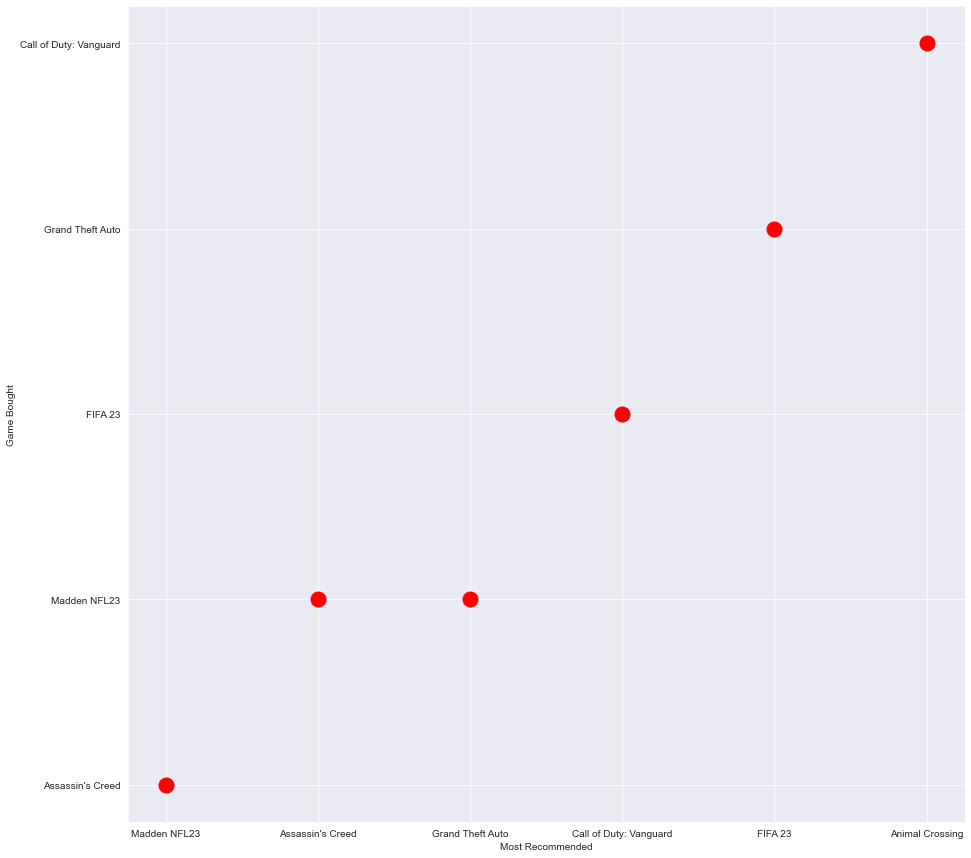

In [7]:


# Find out which product the prospect is most likely to want to buy in each case
tg = []

def getTopRecommendation():
    for i in range(len(games)):
        # Find the highest game (first in the list)
        rec = getRecommendations(games[i]).Item_Name
        tg.append({
            'Game': games[i], 'Pairing': rec[0]
        })

getTopRecommendation()

# Now we have a list of each game, along with its highest affinity recommendation (key/value pair)
print(tg)

# Plot each game
import pylab as pl
f = plt.figure()
plt.xlabel('Most Recommended')
plt.ylabel('Game Bought')

f.set_figwidth(15)
f.set_figheight(15)

# My games and their recommendations are an array of key value pairs
# Plotting the correlation between each game and its top recommendation
# Iterating over each key, and each value
pl.plot([g['Game'] for g in tg], [g['Pairing'] for g in tg], 'ro', markersize=15)

In [8]:
'''
 From the above chart, we can determine:
 - People who bought Grand Theft Auto, Animal Crossing, or Call of Duty should buy FIFA 23
 - People who bought Assassin's Creed should buy Madden NFL23
 - People who bought FIFA 23 should buy Grand Theft Auto
 - People who bought Madden NFL23 should buy Assassin's Creed
'''

# This information could better inform the game store's product placement to increase their sales, ie place Grand Theft Auto, Animal Crossing, Call of Duty near FIFA 23, and so on.


"\n From the above chart, we can determine:\n - People who bought Grand Theft Auto, Animal Crossing, or Call of Duty should buy FIFA 23\n - People who bought Assassin's Creed should buy Madden NFL23\n - People who bought FIFA 23 should buy Grand Theft Auto\n - People who bought Madden NFL23 should buy Assassin's Creed\n"

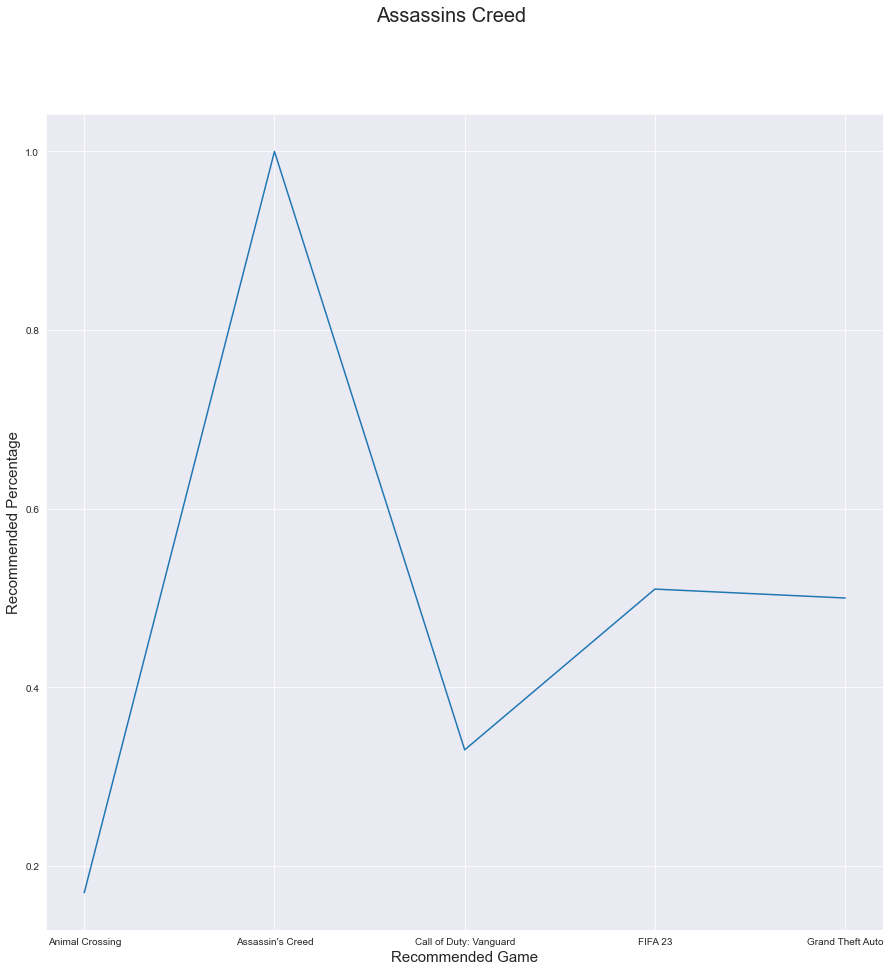

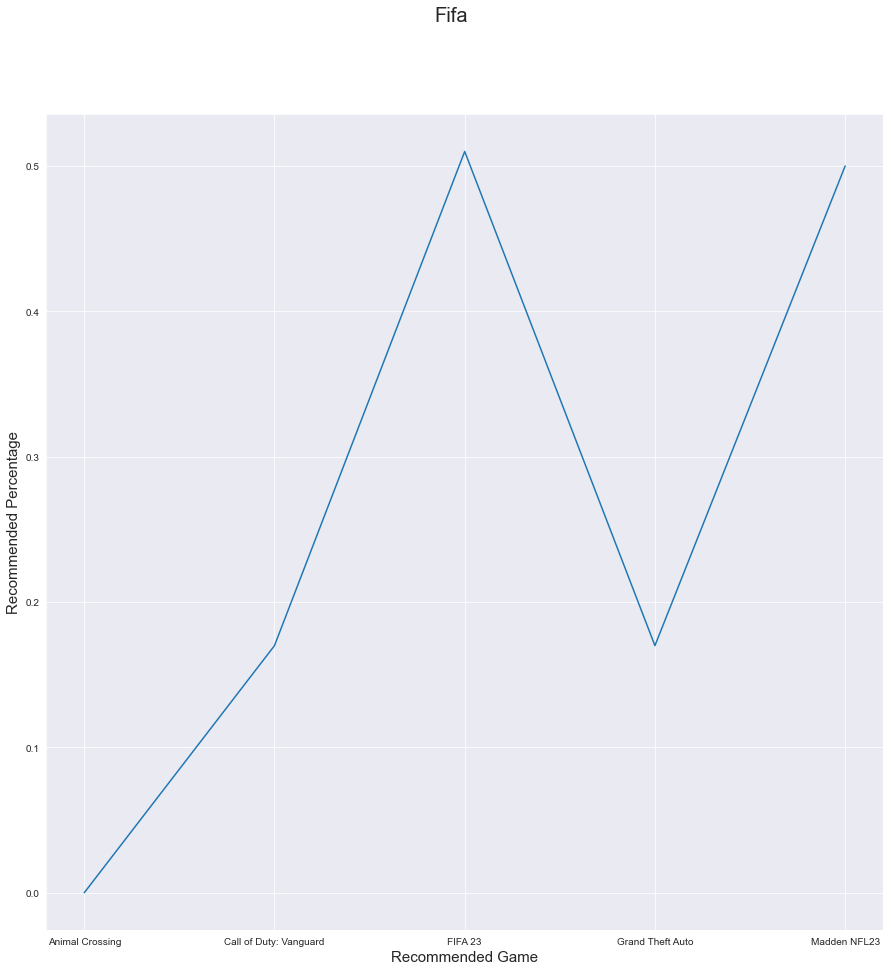

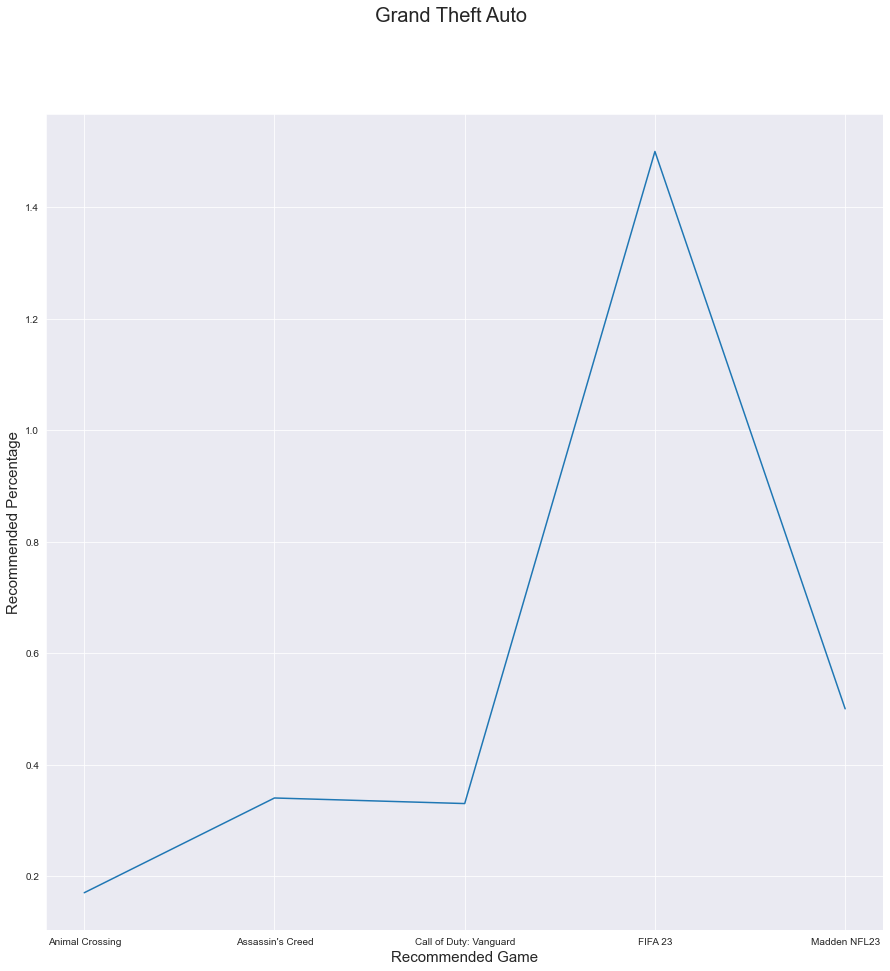

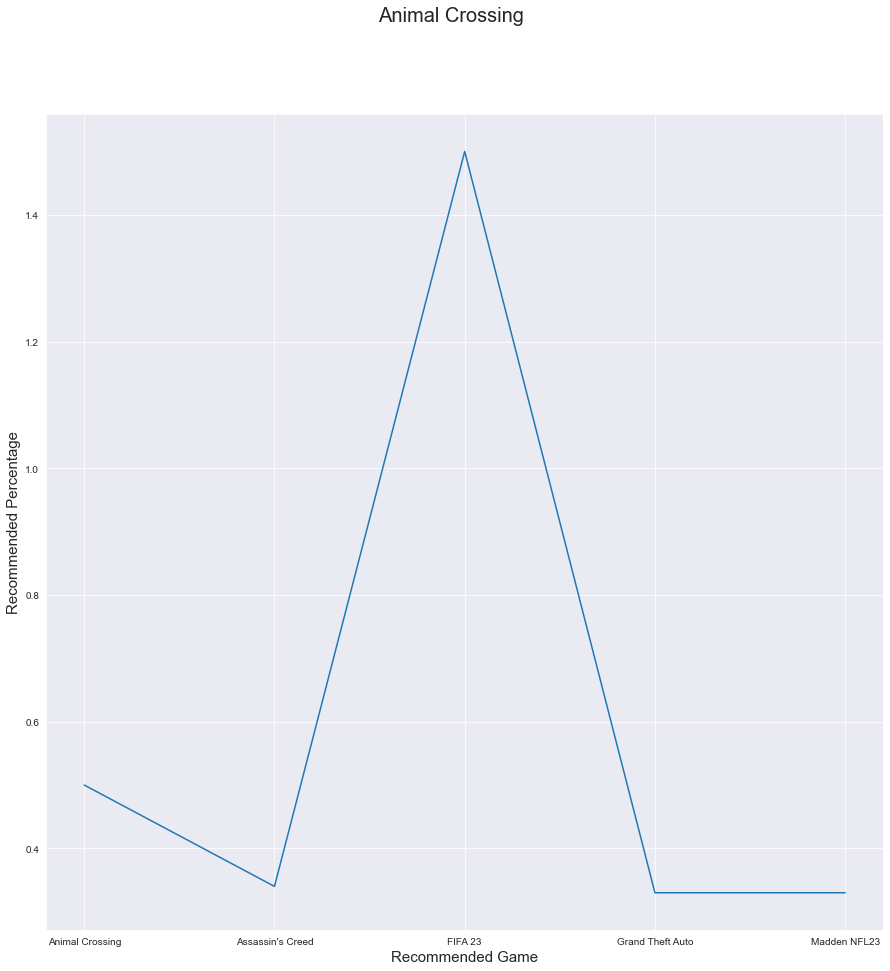

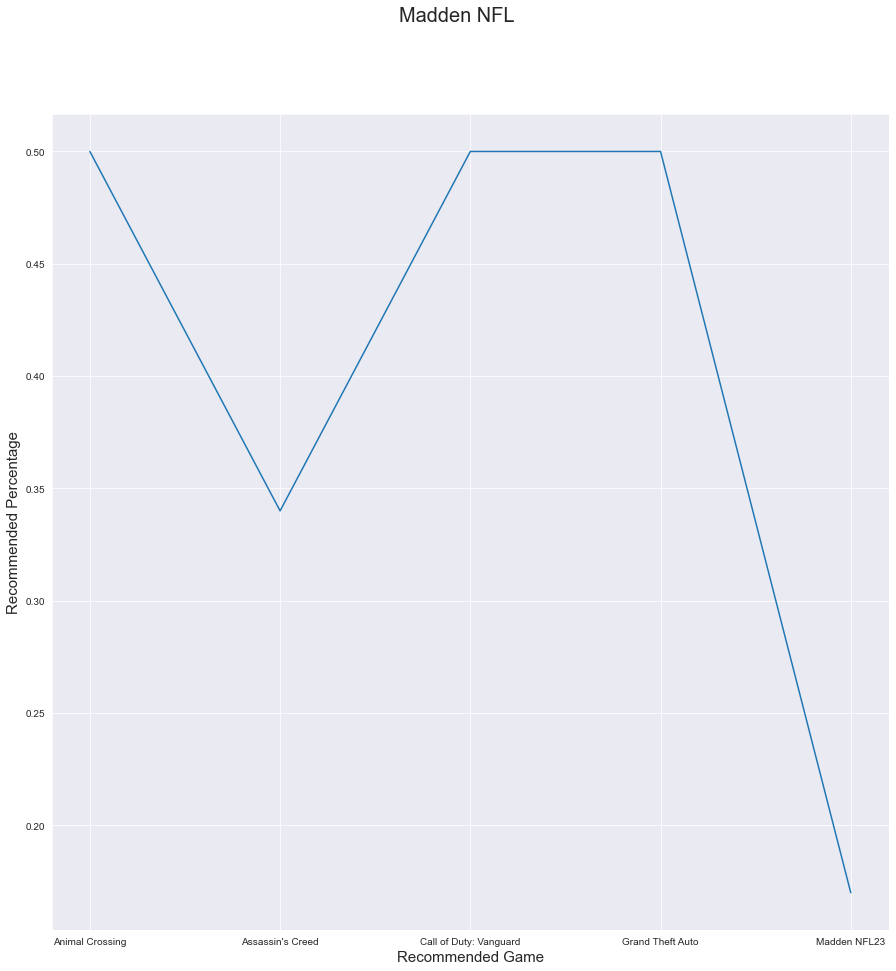

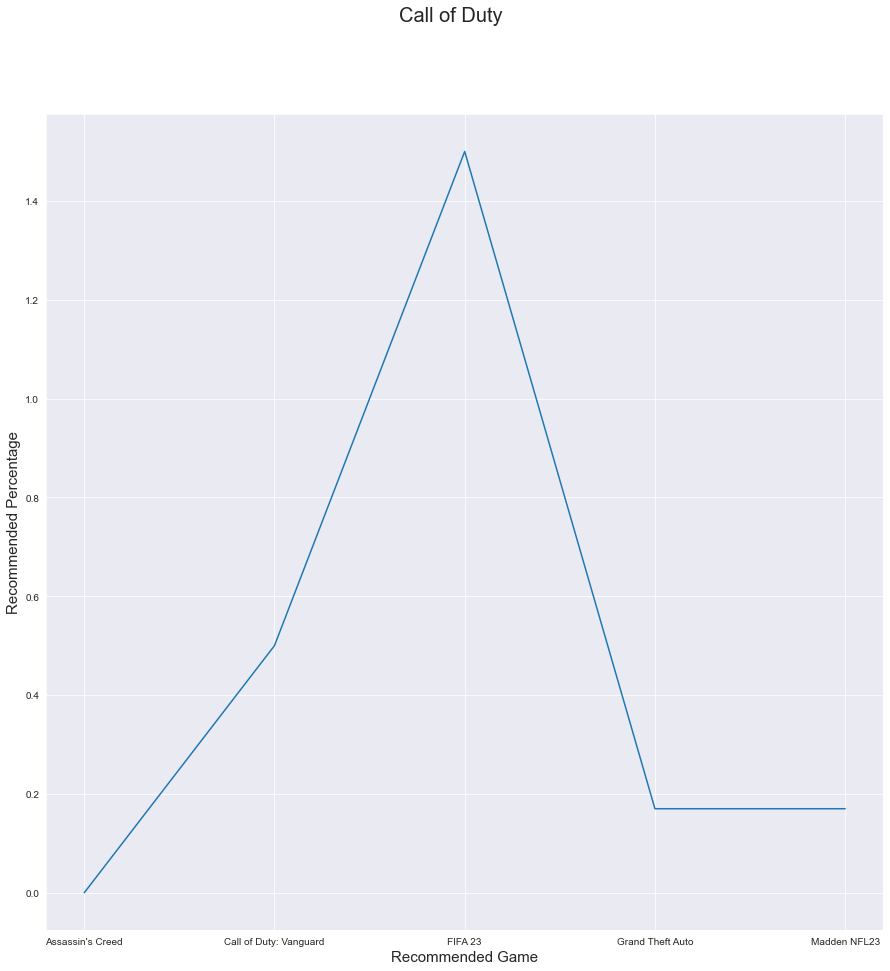

In [21]:
# Finding recommendations and scores for every game, so we can plot them
assassins_creed = getRecommendations(games[0])
fifa_23 = getRecommendations(games[1])
grand_theft_auto = getRecommendations(games[2])
animal_crossing = getRecommendations(games[3])
madden_nfl = getRecommendations(games[4])
call_of_duty = getRecommendations(games[5])

# Setting up games and their lists as key value pairs to iterate over
gameRecs = [
    {'Title': 'Assassins Creed', 'List': assassins_creed},
    {'Title': 'Fifa', 'List': fifa_23},
    {'Title': 'Grand Theft Auto', 'List': grand_theft_auto},
    {'Title': 'Animal Crossing', 'List': animal_crossing},
    {'Title': 'Madden NFL', 'List': madden_nfl},
    {'Title': 'Call of Duty', 'List': call_of_duty}
]


# Generating a line plot for each game and its recommendations (including their score)
def generatePlot(game):
    f = plt.figure()
    plt.xlabel('Recommended Game', fontsize=15)
    plt.ylabel('Recommended Percentage', fontsize=15)

    f.set_figwidth(15)
    f.set_figheight(15)
    plt.suptitle(game['Title'], fontsize=20)
    name_score = game['List'][['Item_Name','score']]
    pl.plot(name_score.groupby(['Item_Name']).sum())

for game in gameRecs:
    generatePlot(game)